In [1]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from pylab import figure, cm
import random
from jax import grad, hessian, jit, vmap
import time
from IPython.display import clear_output


m = 1.0
omega = 1.0
# lam = 0
hbar = 1.0
R = .2
# number of parameters in the ansatz
num_params = 3
# number of coordinates in the ansatz
num_coords = 2
times = []
seed = 5

def psi(coords, params):
    return jnp.exp(-.5 *(coords[0]**2 + coords[1]**2))*(params[0]+params[1]*(coords[0] - coords[1]) + params[2]*(coords[0] - coords[1])**2)
psij = jit(psi)

def psi_neg(coords, params):
    return 1/psi(coords, params)
psi_negj = jit(psi_neg)
def logpsi(coords, params):
    return jnp.log(psij(coords, params))
logpsij = jit(logpsi)

h = hessian(psij)
def ddpsi(coords, params, i):
    return h(coords, params)[i][i]

partials = jit(grad(logpsij, argnums=1))


def V(coords, l):
    return .5 * omega**2 * (coords[0]**2 + coords[1] ** 2) + l * jnp.exp(-((coords[0] - coords[1])/R)**2)
Vj = jit(V)

vddpsi = vmap(ddpsi, in_axes=[0, None], out_axes=0)
def Hpsi(coords, params, l):
    hpsi = Vj(coords, l) * psij(coords, params)
    for i in range(num_coords):
        hpsi += -hbar**2/(2*m)* ddpsi(coords, params, i)
    return hpsi
Hpsij = jit(Hpsi)

def sample(params, num_samples):
    # random.seed(seed)
    outputs = []
    coords_t = [0 for i in range(num_coords)]
    for _ in range(num_samples):
        coords_prime = [0 for i in range(num_coords)]
        for i in range(num_coords):
            coords_prime[i] = coords_t[i] + random.uniform(-1,1)
        if (random.uniform(0,1) < psij(coords_prime, params)**2/psij(coords_t,params)**2):
            coords_t = coords_prime
        outputs.append(coords_t)
    return jnp.array(outputs)

def grad_log_psi(coords, params):
    # this will return a vector of length len(params)
    grad = []
    # now add in the derivatives with respect to each variable
    for i in range(num_params):
        grad.append(partials(coords, params)[i])
    return jnp.array(grad)

def avg_energy(params,l , N=10**3):
    # get N sampled points
    samples = sample(params, N)
    # apply the function to every point
    applied = [(psi_negj(coords, params) * Hpsij(coords, params, l)) for coords in samples]
    return 1/N * np.sum(applied)

vgradlogs = vmap(grad_log_psi, in_axes=(0, None), out_axes=0)
vpsi_neg = vmap(psi_negj, in_axes=(0, None), out_axes=0)
vhpsis = vmap(Hpsij, in_axes=(0, None, None), out_axes=0)
vboth = vmap(jnp.multiply, in_axes=(0, 0), out_axes=0)
def vgradient(params, l, N):
    samples = sample(params, N)
    
    gradlogs = vgradlogs(samples, params)
    hpsis = vhpsis(samples, params, l)
    psi_neg = vpsi_neg(samples, params)


    psi_neg_times_hpsis = jnp.multiply(psi_neg, hpsis)
    # now compute the 3 different averages
    energy_exp = 1/N * jnp.sum(psi_neg_times_hpsis)
    # print("Average Energy: " + str(energy_exp))
    gradlogpsi_exp = 1/N * jnp.sum(gradlogs, 0)
    
    # both_exp = 1/N * jnp.sum(jnp.array([(psi_neg_times_hpsis[i] * gradlogs[i]) for i in range(len(samples))]), 0)
    both_exp = 1/N * jnp.sum(vboth(psi_neg_times_hpsis, gradlogs), 0)
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

def gradient(params, N):
    samples = sample(params, N)
    # first compute all used values to decrease recomputation
    gradlogs = [grad_log_psi(coords, params) for coords in samples]
    
    psi_neg = [1/psi(coords, params) for coords in samples]
    
    hpsis = [Hpsi(coords, params) for coords in samples]
    
    psi_neg_times_hpsis = [(psi_neg[i] * hpsis[i]) for i in range(len(samples))]
    # now compute the 3 different averages
    energy_exp = 1/N * sum([psi_neg_times_hpsis[i] for i in range(len(samples))])
    print("Average Energy: " + str(energy_exp))
    gradlogpsi_exp = 1/N * sum(gradlogs, 0)
    both_exp = 1/N * sum([(psi_neg_times_hpsis[i] * gradlogs[i]) for i in range(len(samples))], 0)
    return (2 * both_exp - 2 * energy_exp * gradlogpsi_exp)

def grad_opt(start_params, learning_rate=.1, max_iterations=100, tolerance=.01, N=10**3):
    # pick the starting position
    params = start_params
    hist = []
    # iterate until we run out of iterations or less than tolerance
    for it in range(max_iterations):
        clear_output(wait=True)
        # compute the gradient at that point
        diff = np.asarray((learning_rate * gradient(params, N)))
        if all((abs(val) < tolerance) for val in diff):
            print("All under tolerance")
            return hist
        # make a step in the direction opposite the gradient
        params = params - diff
        # print(params)
        hist.append(params)
    return hist

def vgrad_opt(start_params, l, learning_rate=.1, max_iterations=100, tolerance=.01, N=10**3):
    # pick the starting position
    params = start_params
    hist = [start_params]
    # iterate until we run out of iterations or less than tolerance
    for it in range(max_iterations):
        #clear_output(wait=True)
        # compute the gradient at that point
        diff = jnp.asarray((learning_rate * vgradient(params, l, N)))
        if all((abs(val) < tolerance) for val in diff):
            print("All under tolerance")
            return hist
        # make a step in the direction opposite the gradient
        params = params - diff
        # print(params)
        hist.append(params)
    return hist

In [ ]:
# comparing unvectorized against vectorized gradient
start = jnp.array([.5, .5, .5])

unvec_start = time.time()
hist = grad_opt(start)
print(time.time() - unvec_start)
optd = hist[-1]
print(optd)

vec_start = time.time()
hist = vgrad_opt(start)
print(time.time() - vec_start)
optd = hist[-1]
print(optd)

In [3]:
start = jnp.array([.5,.5,.5])
hist = vgrad_opt(start, l=0, N=10**3)
optd = hist[-1]
print(optd)

start = jnp.array([.5,.5,.5])
hist = vgrad_opt(start, l=10, N=10**3)
optd = hist[-1]
print(optd)


Average Energy: 1.6708714
Average Energy: 1.5958904
Average Energy: 1.4605457
Average Energy: 1.4143176
Average Energy: 1.2410886
Average Energy: 1.1933744
Average Energy: 1.0888973
Average Energy: 1.0731323
Average Energy: 1.0379655
Average Energy: 1.0377928
Average Energy: 1.0064611
Average Energy: 0.99149036
Average Energy: 0.999295
Average Energy: 0.99534833
Average Energy: 0.99532276
All under tolerance
[0.9081212  0.03598813 0.00463487]
Average Energy: 1.8277879
Average Energy: 1.9510424
Average Energy: 1.9289566
Average Energy: 1.9905488
Average Energy: 1.867805
Average Energy: 1.8125197
Average Energy: 1.9385499
All under tolerance
[0.5753703  0.46584707 0.45262158]


In [ ]:

x = jnp.array([[1.0,1.0],[2.0,2.0],[3.,3.]])
y = jnp.array([1.,1.,1.])
def test(a,b):
    # this will return a vector of length len(params)
    grad = []
    # now add in the derivatives with respect to each variable
    for i in range(len(b)):
        grad.append(partials(a, b)[i])
    return jnp.array(grad)


vtest = vmap(grad_log_psi, in_axes=(0, None), out_axes=0)
print(vtest(x, y))

In [ ]:
test = jnp.array([.5,.5,.5])
# start_time = time.time()
# print(gradient(test, 10**3))
# print(time.time() - start_time)
start_time = time.time()
print(vgradient(test, 10**3))
print(time.time() - start_time)

In [ ]:
# get a contour plot of the wavefunction
size = 100
xmin = -5
xmax = 5
ymin = -5
ymax = 5

X = np.linspace(xmin, xmax, size)
Y = np.linspace(ymin, ymax, size)
Z = [[psi([i, j], optd) for i in X] for j in Y]

In [ ]:
print(optd)
plt.title(r"$\lambda = 10$, $R = .2$")
plt.imshow(Z,extent=[xmin, xmax, ymin, ymax], cmap=cm.jet, origin='lower')
#plt.contour(X,Y,Z)
plt.show()

In [5]:
## get the data for a series of plots with varying lambda levels
lambdas = np.linspace(0, 10, 10)
wfs = []
for i in range(len(lambdas)):
    if i == 0:
        start = jnp.array([.5,.5,.5])
    else:
        start = wfs[i - 1]

    # do the optimization
    hist = vgrad_opt(start, i)
    wfs.append(hist[-1])

Average Energy: 1.6918614
Average Energy: 1.6700174
Average Energy: 1.4817348
Average Energy: 1.3794397
Average Energy: 1.1745434
Average Energy: 1.0632242
Average Energy: 1.1120938
Average Energy: 1.038564
Average Energy: 1.0241895
Average Energy: 1.0334316
Average Energy: 1.0130509
Average Energy: 1.0136607
Average Energy: 1.0128627
Average Energy: 0.99550873
Average Energy: 1.0026364
All under tolerance
[DeviceArray([0.5, 0.5, 0.5], dtype=float32), DeviceArray([0.5797731 , 0.49155605, 0.4286709 ], dtype=float32), DeviceArray([0.6500541 , 0.4871847 , 0.33862913], dtype=float32), DeviceArray([0.73009926, 0.4421962 , 0.24969414], dtype=float32), DeviceArray([0.7809572 , 0.39871898, 0.1779828 ], dtype=float32), DeviceArray([0.8252892 , 0.34393004, 0.10620074], dtype=float32), DeviceArray([0.8536129 , 0.28454807, 0.0784038 ], dtype=float32), DeviceArray([0.87600666, 0.2300826 , 0.03226351], dtype=float32), DeviceArray([0.89031297, 0.17694229, 0.0227878 ], dtype=float32), DeviceArray([0.8

In [6]:
# now make a series of plots with all the data
size = 100
xmin = -5
xmax = 5
ymin = -5
ymax = 5
X = np.linspace(xmin, xmax, size)
Y = np.linspace(ymin, ymax, size)
meshes = []

for k in range(len(lambdas)):
    meshes.append([[psij([i, j], wfs[k]) for i in X] for j in Y])

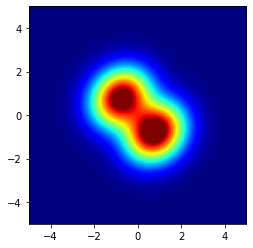

In [7]:

fig = plt.figure()

im = plt.imshow(meshes[0], cmap=plt.get_cmap('jet'), extent=[xmin, xmax, ymin, ymax], origin='lower')

def updatefig(j):
    # set the data in the axesimage object
    im.set_array(meshes[j])
    # return the artists set
    return [im]


ani = animation.FuncAnimation(fig, updatefig, frames=range(len(lambdas)), 
                              interval=200, blit=False)
f = r"animation.gif" 
writergif = animation.PillowWriter(fps=2) 
ani.save(f, writer=writergif)
